# MNIST

# 1. Training & Loading

In [1]:
import numpy as np
import torch
from torch import nn
import flow
import train
import utils
import math
import h5py

# Set gobal variables.

rootFolder = "./demo/MNIST_relax_True_shift_True_T_300_depthLevel_1_l16_M3_H680/"
device = torch.device("cpu")
dtype = torch.float32
dataset = "./database/mnist.npz"
labdata = "./database/mnistlabs.npz"

# Load paremeters

with h5py.File(rootFolder+"/parameter.hdf5","r") as f:
    n = int(np.array(f["n"]))
    numFlow = int(np.array(f["numFlow"]))
    lossPlotStep = int(np.array(f["lossPlotStep"]))
    hidden = int(np.array(f["hidden"]))
    nlayers = int(np.array(f["nlayers"]))
    nmlp = int(np.array(f["nmlp"]))
    lr = int(np.array(f["lr"]))
    batchSize = int(np.array(f["batchSize"]))
    epochs = int(np.array(f["epochs"]))
    K = int(np.array(f["K"]))
    
# Build the target.

from utils import MDSampler,load
dataset = load(dataset).to(device).to(dtype)
datasetlabs = torch.from_numpy(np.argmax(np.load(labdata)["arr_0"],axis=1)).to(device).to(dtype)
target = MDSampler(dataset)
    
# Rebuild the model.

def innerBuilder(num):
    maskList = []
    for i in range(nlayers):
        if i %2==0:
            b = torch.zeros(num)
            i = torch.randperm(b.numel()).narrow(0, 0, b.numel() // 2)
            b.zero_()[i] = 1
            b=b.reshape(1,num)
        else:
            b = 1-b
        maskList.append(b)
    maskList = torch.cat(maskList,0).to(torch.float32)
    fl = flow.RNVP(maskList, [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[None]) for _ in range(nlayers)], [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[utils.ScalableTanh(num)]) for _ in range(nlayers)])
    return fl

from utils import flowBuilder

f = flowBuilder(n,numFlow,innerBuilder,1).to(device).to(dtype)

# Load saving.

import os
import glob
name = max(glob.iglob(rootFolder+"savings/"+'*.saving'), key=os.path.getctime)
print("load saving at "+name)
saved = torch.load(name,map_location=device)
f.load(saved);

/Users/lili/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


load saving at ./demo/MNIST_relax_True_shift_True_T_300_depthLevel_1_l16_M3_H680/savings/FlowNetSaving_epoch390.saving


# 2. Analysis

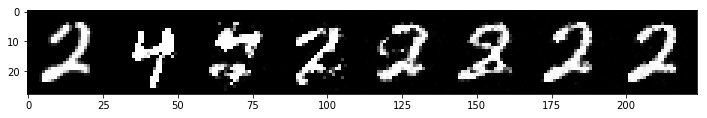

In [2]:
# Calculate modes in the latent space.

d0 = f.layerList[0].elements[:n]
d1 = f.layerList[0].elements[n:]
omega = (1/(torch.exp(d0+d1))).detach()

from matplotlib import pyplot as plt
from utils import logit_back,logit

from copy import deepcopy
omega, idx = torch.sort(omega)
original = target.sample(1)
saveList = [original[:,:784].reshape(28,28)]
z = f.forward(original)[0].detach()
for nslow in [5,10,15,20,25,30,35]:
    noise = torch.randn(nslow)
    zz = deepcopy(z)
    zz[:,idx[nslow:784]] = f.layerList[0].inverse(torch.randn(original.shape))[0][:,idx[nslow:784]]
    saveList.append(f.inverse(zz)[0].detach()[:,:784].reshape(28,28))
imgs = torch.cat(saveList,1)

plt.figure(figsize=(12,4))
plt.imshow(logit_back(imgs),cmap="gray")
plt.show()

In [3]:
# cluster plot.
def plot2DCluster(model,data,label,idx):
    tmp = torch.randn(data.shape)
    datap = torch.cat([data,tmp],dim = 1)
    zs = model.forward(datap)[0].detach()[:,:28*28]
    plt.figure(figsize=(12,12))
    plotdata = [[] for _ in range(10)]
    colormap = ["black","peru","darkorange","tan","olive","green","red","lightslategray","blue","purple"]
    for no,lb in enumerate(label):
        i = int(lb.item())
        plotdata[i].append((zs[no][idx[0]],zs[no][idx[1]]))
    plotdata = [np.array(plotdata[i]) for i in range(10)]
    for i in range(10):
        if len(plotdata[i]) == 0:
            continue
        plt.scatter(plotdata[i][:,0],plotdata[i][:,1],c=colormap[i],label=str(i))
    plt.legend()
    plt.show()
        
    

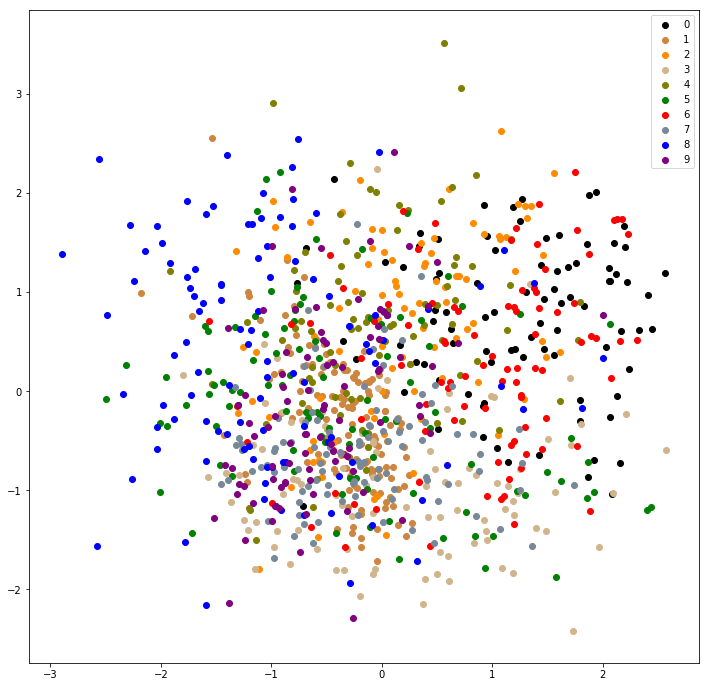

In [4]:
sampleSize = 1000
idxs = np.random.randint(0,dataset.shape[0],sampleSize)
sampleset = dataset[idxs]
samplelabs = datasetlabs[idxs]
plot2DCluster(f,sampleset,samplelabs,idx)